# AIML CA1 Assignment (Part A)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# 0. How is your prediction task defined? And what is the meaning of the output variable?


This prediction task is defined as predicting water quality based on water properties such as pH, Clarity, Conductivity etc. 

The meaning of the output variable, which is Quality, is defined by 0 being of bad quality and 1 being of good quality

After some background research, I have an idea of what each feature means.
- ph: The pH level (concentration of H+ ions) found in the water / how acid the water is, where water with a pH 7 is deemed neutral.

- Hardness: Concentrations of calcium, magnesium and other dissolved minerals in the water. A high hardness level will cause damage to water-using appliances.

- Solids: Concentration of dissolved solids plus suspended and settleable solids in the water. High levels of solids can serve as carriers of toxins.

- Chloramines: Cocnentration of chloramines in the water which are disinfectants used to treat drinking water to prevent contamination with germs.

- Sulfate: Concentration of sulfates in the water which are natural. High concentrations of sulfate in the water can however have a laxative effect when combined with calcium and magnesium, the two most common constituents of hardness.

- Conductivity: Measure of the ability of the water to pass an electrical current. A conductivity outside of a certain range can make the water not safe for certain species of fishes.

- Organic Carbon: Measure the amount of organic compounds contained in the water.

- Trihalomethanes: Concentration of the amount of Trihalomethanes in the water which are byproducts of water treatment processes produced by reactions with chlorine.

- Clarity: Measure of how far down light can penetrate through the water column in the water which can affect biodiversity living in the water

### Outline of the task:
1. Load data
2. Remove duplicative data (if any)
3. Remove missing data (if any)
4. Remove outliers (if any)
5. Impute missing data (if any)
6. Scale data
7. Test which models favor which type of data (scale/unscaled & with outliers/without outliers)
8. Hypertune models
9. Select best model by score
10. Comapre with dummy baseline

# 1. Load Data

In [2]:
df = pd.read_csv('D:\\randal\\SP\\Year 1 Sem 2\\ST1511 AI & Machine Learning\\CA1\\CA1-Dataset\\CA1-Classification-Dataset.csv')
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Clarity,Quality
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


# 2. Data Preprocessing

## A. Analyse Missing/Duplicative Data

### 1. Check for duplicative data

In [3]:
df[df.duplicated(keep=False)]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Clarity,Quality


Since there is no results, there are no duplicative data

### 2. Check for missing data

<Axes: >

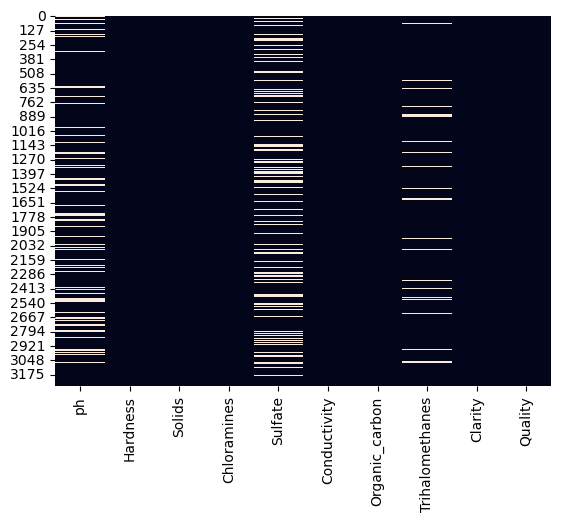

In [4]:
# view missing data
sns.heatmap(df.isnull(), cbar=False)

In [5]:
# view number of missing values
df.isnull().sum().sort_values()

Hardness             0
Solids               0
Chloramines          0
Conductivity         0
Organic_carbon       0
Clarity              0
Quality              0
Trihalomethanes    162
ph                 491
Sulfate            781
dtype: int64

In [6]:
# view percentage of missing values
print(f"Percentage of data that are missing in 'Trihalomethanes': {((df['Trihalomethanes'].isnull().sum() / len(df)) * 100):.2f}%")
print(f"Percentage of data that are missing in 'ph': {((df['ph'].isnull().sum() / len(df)) * 100):.2f}%")
print(f"Percentage of data that are missing in 'Sulfate': {((df['Sulfate'].isnull().sum() / len(df)) * 100):.2f}%")
print(f"Percentage of all the data that are missing: {((df.isnull().values.sum() / (len(df) * df.shape[1])) * 100):.2f}%")

Percentage of data that are missing in 'Trihalomethanes': 4.95%
Percentage of data that are missing in 'ph': 14.99%
Percentage of data that are missing in 'Sulfate': 23.84%
Percentage of all the data that are missing: 4.38%


Since the percentage of missing data is quite significant (>=5%), we will not drop the missing data

Instead, we can either impute by median or mean

But first, we need to remove outliers in our data (if any), so that the imputed values for the missing data will be more accurate

## B. Visualise Distribution of Feature Data

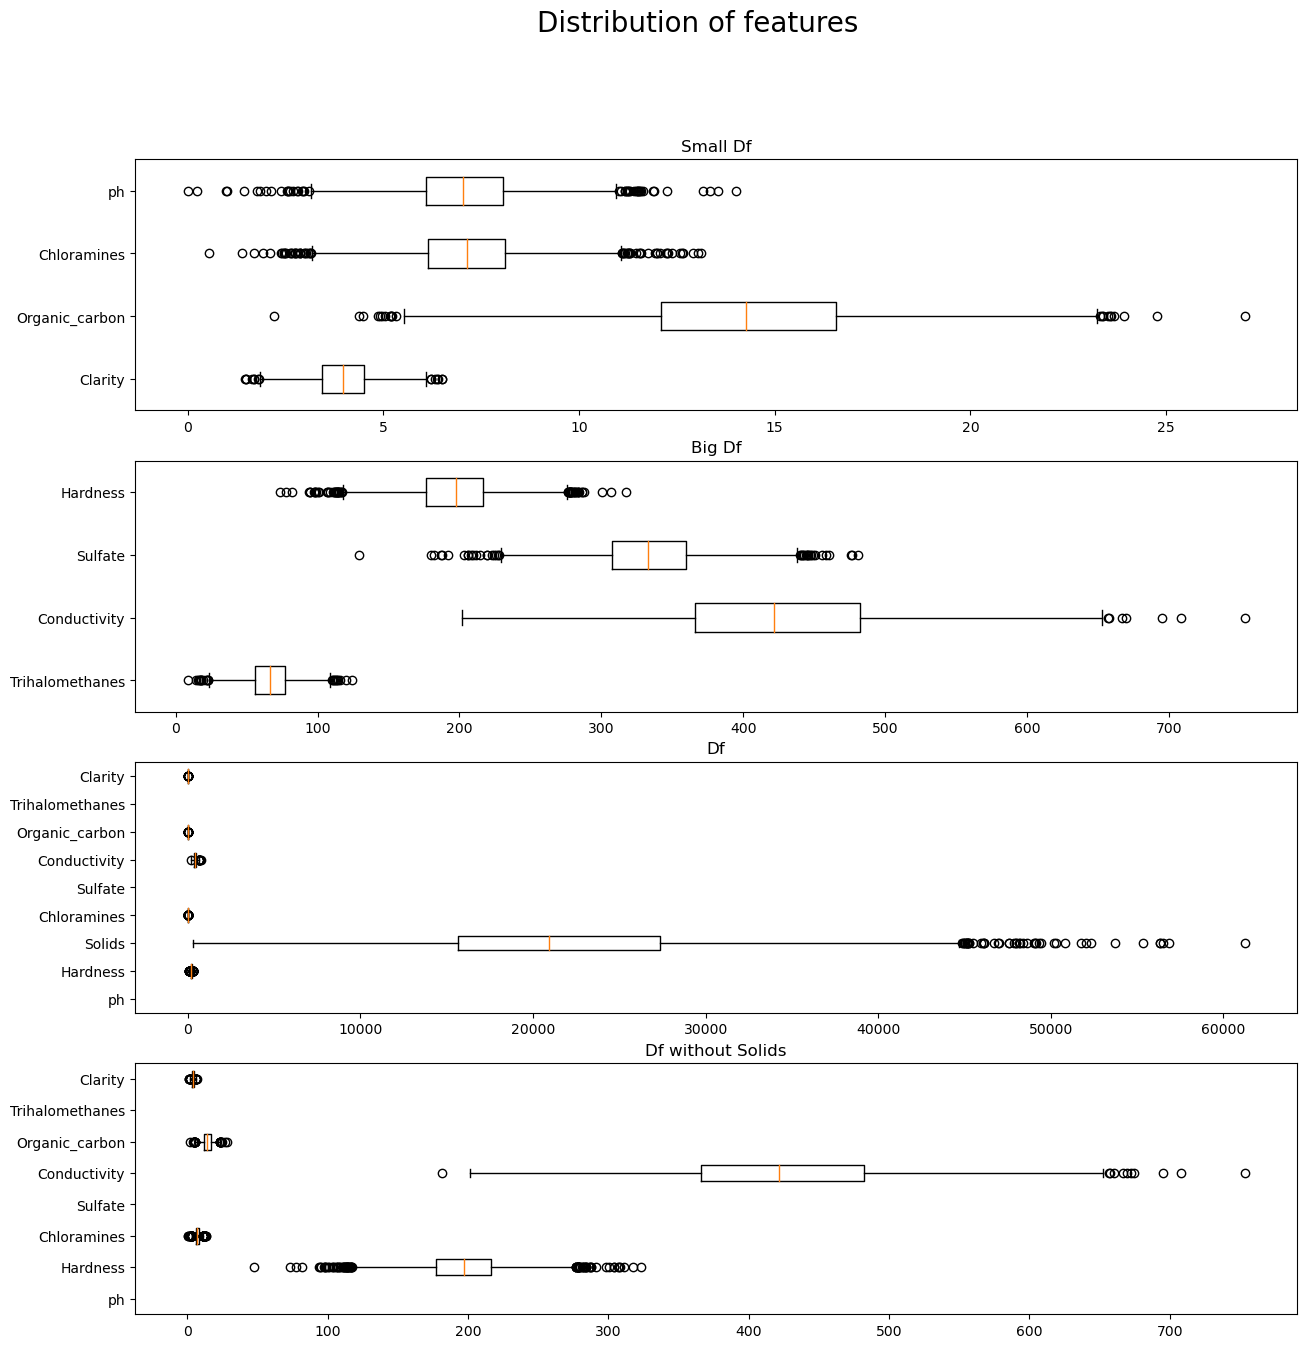

In [7]:
small_df = df[['Clarity', 'Organic_carbon', 'Chloramines', 'ph']].dropna()  # features that have a small value without missing values
big_df = df[['Trihalomethanes', 'Conductivity', 'Sulfate', 'Hardness']].dropna()  # features that have a large value without missing values

# plot boxplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))

fig.suptitle('Distribution of features', fontsize=20)

# view the boxplot of small valued features
ax1.boxplot(small_df, vert=False)
ax1.set_yticks(np.arange(1, 5), small_df.columns)
ax1.set_title('Small Df')

# view the boxplot of large valued features
ax2.boxplot(big_df, vert=False)
ax2.set_yticks(np.arange(1, 5), big_df.columns)
ax2.set_title('Big Df')

# view the boxplot of all the features
ax3.boxplot(df.drop(['Quality'], axis=1), vert=False)
ax3.set_yticks(np.arange(1, 10), df.drop(['Quality'], axis=1).columns)
ax3.set_title('Df')

# view the boxplot of all the features except for 'Solids' as it is too big
ax4.boxplot(df.drop(['Quality', 'Solids'], axis=1), vert=False)
ax4.set_yticks(np.arange(1, 9), df.drop(['Quality', 'Solids'], axis=1).columns)
ax4.set_title('Df without Solids')

plt.show()

From the boxplot above, we can see that there are quite a few outliers in features such as 'Solids', so we can try removing outliers using the IQR method and see whether that will improve model performance

## C. Remove Outliers From Features

In [8]:
# create a separate copy of df
outliers_df = df.copy(deep=True)

for feature in df.drop(['Quality'], axis=1).columns:
    # calculating IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # removing outliers
    df = df[(df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 * IQR) | df[feature].isnull()]  # keeps data that are within range or missing values

# verify that outliers have been removed
print(outliers_df.shape)
print(df.shape)

(3276, 10)
(2942, 10)


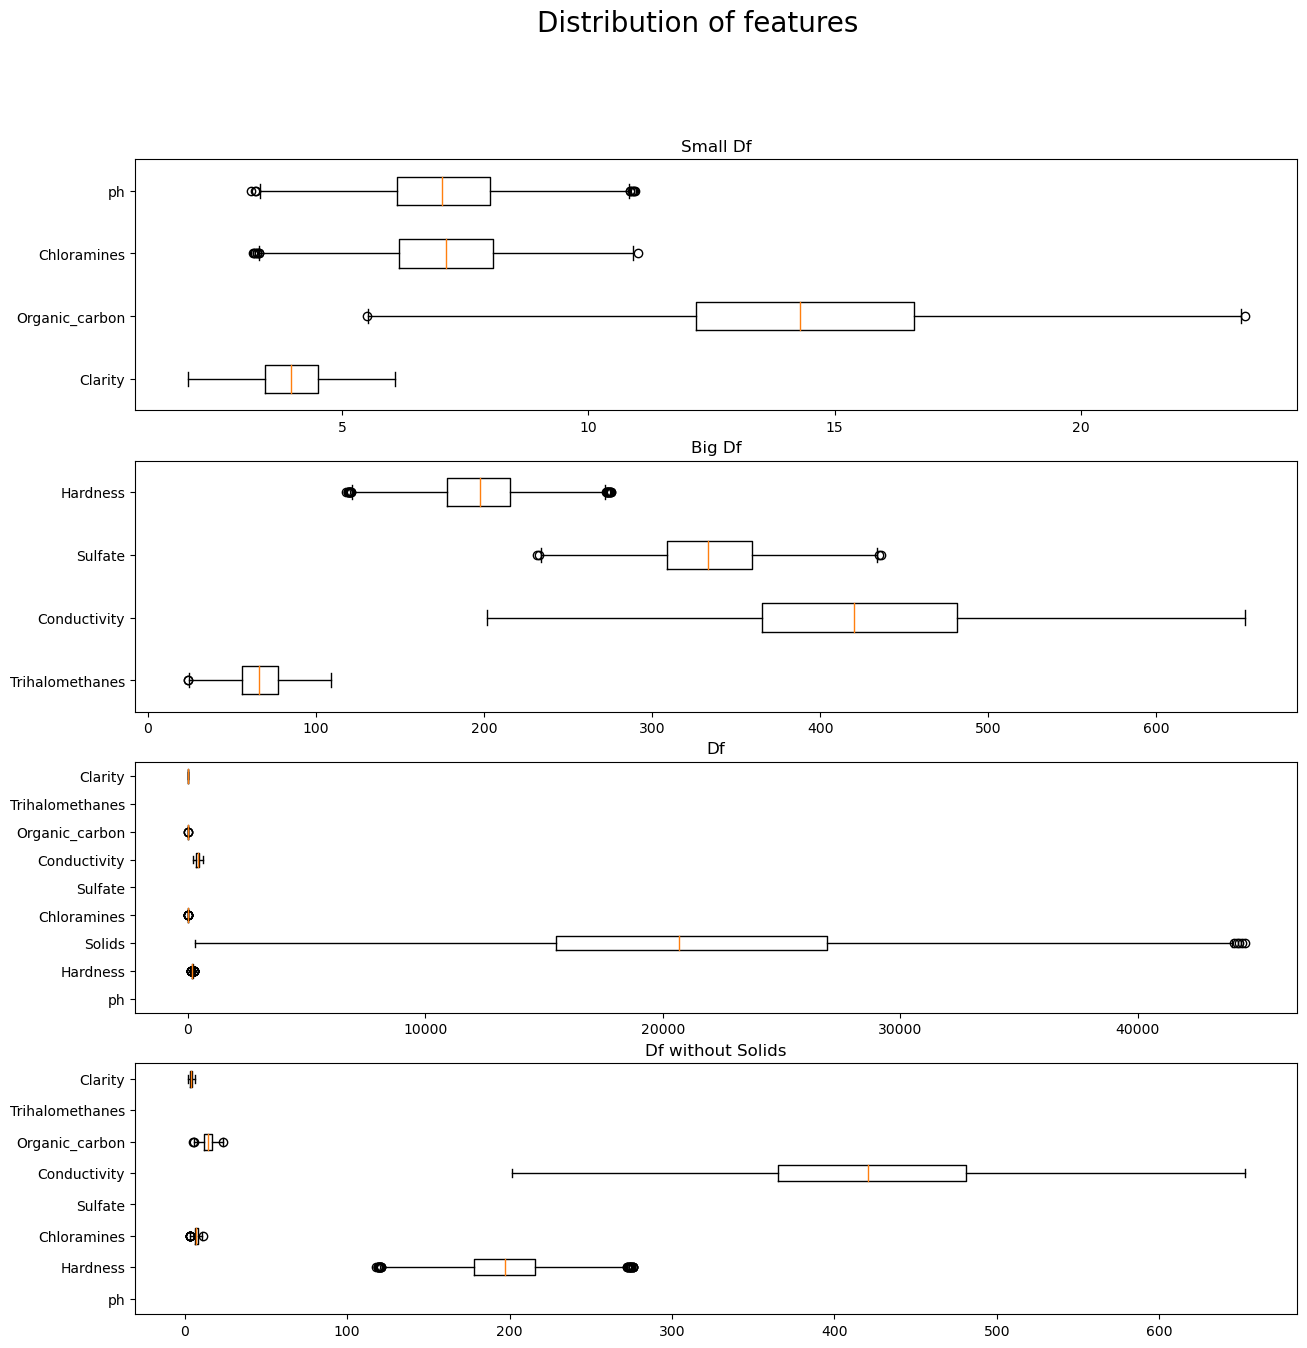

In [9]:
small_df = df[['Clarity', 'Organic_carbon', 'Chloramines', 'ph']].dropna()  # features that have a small value without missing values
big_df = df[['Trihalomethanes', 'Conductivity', 'Sulfate', 'Hardness']].dropna()  # features that have a large value without missing values

# plot boxplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))

fig.suptitle('Distribution of features', fontsize=20)

# view the boxplot of small valued features
ax1.boxplot(small_df, vert=False)
ax1.set_yticks(np.arange(1, 5), small_df.columns)
ax1.set_title('Small Df')

# view the boxplot of large valued features
ax2.boxplot(big_df, vert=False)
ax2.set_yticks(np.arange(1, 5), big_df.columns)
ax2.set_title('Big Df')

# view the boxplot of all the features
ax3.boxplot(df.drop(['Quality'], axis=1), vert=False)
ax3.set_yticks(np.arange(1, 10), df.drop(['Quality'], axis=1).columns)
ax3.set_title('Df')

# view the boxplot of all the features except for 'Solids' as it is too big
ax4.boxplot(df.drop(['Quality', 'Solids'], axis=1), vert=False)
ax4.set_yticks(np.arange(1, 9), df.drop(['Quality', 'Solids'], axis=1).columns)
ax4.set_title('Df without Solids')

plt.show()

Comparing the two box plots before and after removing outliers, we can see that there are less circles for each boxplot, meaning that the outliers have successfully been removed

## D. Visualise Distributions of Features With Missing Data

To decide on which method to use, we can first take a look at the distribution of the features with missing data

### i. Trihalomethanes

<Axes: xlabel='Trihalomethanes', ylabel='Count'>

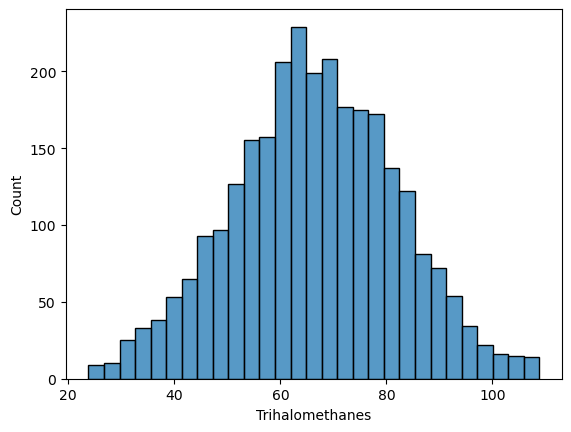

In [10]:
# plot histplot plot
sns.histplot(x=df['Trihalomethanes'])

### ii. ph

<Axes: xlabel='ph', ylabel='Count'>

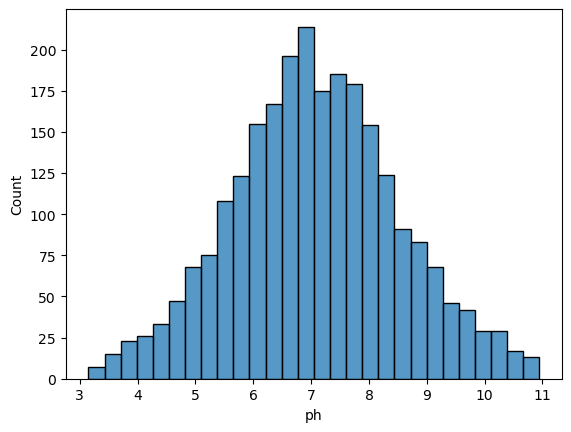

In [11]:
# plot histplot plot
sns.histplot(x=df['ph'])

### iii. Sulfate

<Axes: xlabel='Sulfate', ylabel='Count'>

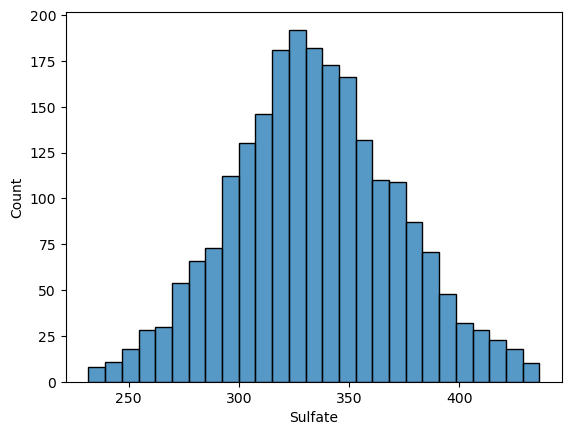

In [12]:
# plot histplot plot
sns.histplot(x=df['Sulfate'])

Since the features are more or less normally distributed without much outliers, we shall use mean as our method of imputation

## E. Impute Missing Data Using Mean

In [13]:
# impute for each feature for both df with and without outliers
for feature_name in ['ph', 'Sulfate', 'Trihalomethanes']:
    df[feature_name] = df[feature_name].fillna(df[feature_name].mean())
    outliers_df[feature_name] = outliers_df[feature_name].fillna(outliers_df[feature_name].mean())

# check if missing data have been imputed
print(f'df without outliers:\n{df.isnull().sum()}')
print()
print(f'df with outliers:\n{outliers_df.isnull().sum()}')

df without outliers:
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Clarity            0
Quality            0
dtype: int64

df with outliers:
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Clarity            0
Quality            0
dtype: int64


## F. Test Which Model Works Better With Or Without Outliers

We will loop through a dictionary of Classification models that we plan on using and train and test them to get their scores for data with and without outliers. All the hyperparameters will be the same such as number of cross_validation folds

In [14]:
# classification models
models = {
    'KNN': KNeighborsClassifier,
    'DecisionTree': DecisionTreeClassifier,
    'LogisticRegression': LogisticRegression,
    'SVC': SVC,
    'GaussianNB': GaussianNB
}

mean_scores_with_outliers = []
mean_scores_without_outliers = []

with_outliers_models = []
without_outliers_models = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)  # split the data into equal proportions and randomise them

# train test split with outliers
X_with_outliers = outliers_df.drop(['Quality'], axis=1).values
y_with_outliers = outliers_df['Quality'].values
X_train_with_outliers, X_test_with_outliers, y_train_with_outliers, y_test_with_outliers = train_test_split(
    X_with_outliers, y_with_outliers, random_state=21, test_size=0.2, stratify=y_with_outliers
)

# train test split without outliers
X_without_outliers = df.drop(['Quality'], axis=1).values
y_without_outliers = df['Quality'].values
X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, y_test_without_outliers = train_test_split(
    X_without_outliers, y_without_outliers, random_state=21, test_size=0.2, stratify=y_without_outliers
)

for model in models:
    # train and score each model with outlier
    model_with_outliers = models[model]()  # instantiate a new model instance
    model_with_outliers.fit(X_train_with_outliers, y_train_with_outliers)
    y_pred = model_with_outliers.predict(X_test_with_outliers)
    score = cross_val_score(
        model_with_outliers, X_train_with_outliers, y_train_with_outliers, cv=skf, n_jobs=-1, scoring='f1_weighted'
    )
    
    mean_scores_with_outliers.append((model, np.mean(score)))
    
    print(f'{model} With Outlier Score: {np.mean(score)}')
    
    # train and score each model without outlier    
    model_without_outliers = models[model]()  # instantiate a new model instance
    model_without_outliers.fit(X_train_without_outliers, y_train_without_outliers)
    y_pred = model_without_outliers.predict(X_test_without_outliers)
    score = cross_val_score(
        model_without_outliers, X_train_without_outliers, y_train_without_outliers, cv=skf, n_jobs=-1, scoring='f1_weighted'
    )
    
    mean_scores_without_outliers.append((model, np.mean(score)))
    
    print(f'{model} Without Outlier Score: {np.mean(score)}')
    
    print()
    
for i in range(len(models)):
    if (mean_scores_with_outliers[i][1] - mean_scores_without_outliers[i][1]) >= 0:  # positive difference meaning that score increased with with outliers or no difference
        print(f'{mean_scores_with_outliers[i][0]} should be used with outliers')
        with_outliers_models.append(mean_scores_with_outliers[i][0])  # save the model names into a list
    else:
        print(f'{mean_scores_with_outliers[i][0]} should be used without outliers')
        without_outliers_models.append(mean_scores_with_outliers[i][0])  # save the model names into a list
        
print()
print(f'With Outlier Models: {with_outliers_models}')
print(f'Without Outlier Models: {without_outliers_models}')

KNN With Outlier Score: 0.5411168768387775
KNN Without Outlier Score: 0.5454443278994571

DecisionTree With Outlier Score: 0.5742082277717597
DecisionTree Without Outlier Score: 0.5625372395802803

LogisticRegression With Outlier Score: 0.4635135242759551
LogisticRegression Without Outlier Score: 0.4745589474629483

SVC With Outlier Score: 0.46178243919702655
SVC Without Outlier Score: 0.4735898639489008

GaussianNB With Outlier Score: 0.5697409580210635
GaussianNB Without Outlier Score: 0.5380822945077561

KNN should be used without outliers
DecisionTree should be used with outliers
LogisticRegression should be used without outliers
SVC should be used without outliers
GaussianNB should be used with outliers

With Outlier Models: ['DecisionTree', 'GaussianNB']
Without Outlier Models: ['KNN', 'LogisticRegression', 'SVC']


We initially used f1_score for the scoring of cross_val_score instead of other scoring methods such as accuracy. For example, we want to correctly predict the quality of water. Be it 0 or 1, we want to get the correct prediction. However, the formula for accuracy is TP / (TP + TN). This only accounts for the number of correct 1s we predicted and not the number of correct 0s we predicted. On the other hand, the formula for f1_score is F1 = (2 × TP) / (2 × TP + FP + FN) or F1 = (2 × Precision × Recall) / (Precision + Recall) which takes into account the false positives and false negatives.

However, when I used f1_score for the scoring of cross_val_score, it gave me a score of 0 for Logistic Regression. After printing out its predictions, I realised that it predicted all 0 for the target. This is because the distribution of the target is inbalanced (not 50-50) and there is more data in the dataset that trains the model to predict 0 than 1 which can be shown by the countplot below. As the model predicts all 0s, the number of TP is 0 and thus F1 score is 0.

Hence, we decided to use weighted_f1 for the scoring of cross_val_score as it assigns weights to each class based on the number of instances in that class which gives a score representative of the imbalance in the class. 

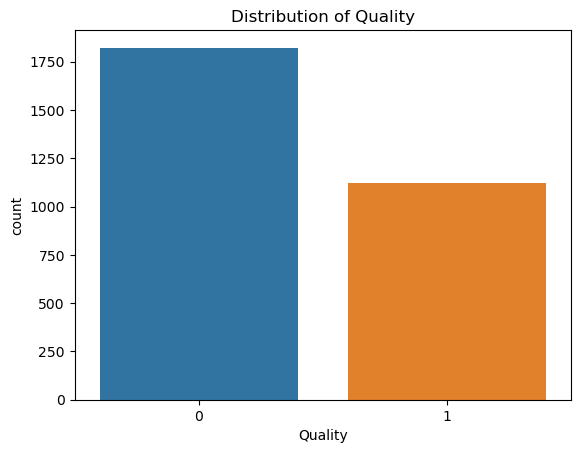

In [15]:
sns.countplot(x='Quality', data=df)
plt.title('Distribution of Quality')
plt.show()

## G. Scale Features Using Standardisation

In [16]:
# with outliers
# perform train-test-split
X_outliers = outliers_df.drop(['Quality'], axis=1).values
y_outliers = outliers_df['Quality'].values
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(
    X_outliers, y_outliers, random_state=42, test_size=0.2, stratify=y_outliers
)

# scale data by standardisation
scaler = StandardScaler()
X_train_scaled_outliers = scaler.fit_transform(X_train_outliers)
X_test_scaled_outliers = scaler.transform(X_test_outliers)

print('----------- Dataset With Outliers -----------')
print()
print(f'Mean of X_train_outliers: {round(np.mean(X_train_outliers))}')
print(f'Standard Deviation of X_train_outliers: {round(np.std(X_train_outliers))}')
print()
print(f'Mean of X_test_outliers: {round(np.mean(X_test_outliers))}')
print(f'Standard Deviation of X_test_outliers: {round(np.std(X_test_outliers))}')
print()
print(f'Mean of X_train_scaled_outliers: {round(np.mean(X_train_scaled_outliers))}')
print(f'Standard Deviation of X_train_scaled_outliers: {round(np.std(X_train_scaled_outliers))}')
print()
print(f'Mean of X_test_scaled_outliers: {round(np.mean(X_test_scaled_outliers))}')
print(f'Standard Deviation of X_test_scaled_outliers: {round(np.std(X_test_scaled_outliers))}')
print()

# without outliers
# perform train-test-split
X = df.drop(['Quality'], axis=1).values
y = df['Quality'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# scale data by standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('----------- Dataset Without Outliers -----------')
print()
print(f'Mean of X_train: {round(np.mean(X_train))}')
print(f'Standard Deviation of X_train_outliers: {round(np.std(X_train))}')
print()
print(f'Mean of X_test: {round(np.mean(X_test))}')
print(f'Standard Deviation of X_test_outliers: {round(np.std(X_test))}')
print()
print(f'Mean of X_train_scaled: {round(np.mean(X_train_scaled))}')
print(f'Standard Deviation of X_train_scaled: {round(np.std(X_train_scaled))}')
print()
print(f'Mean of X_test_scaled: {round(np.mean(X_test_scaled))}')
print(f'Standard Deviation of X_test_scaled: {round(np.std(X_test_scaled))}')

----------- Dataset With Outliers -----------

Mean of X_train_outliers: 2549
Standard Deviation of X_train_outliers: 7436

Mean of X_test_outliers: 2618
Standard Deviation of X_test_outliers: 7622

Mean of X_train_scaled_outliers: 0
Standard Deviation of X_train_scaled_outliers: 1

Mean of X_test_scaled_outliers: 0
Standard Deviation of X_test_scaled_outliers: 1

----------- Dataset Without Outliers -----------

Mean of X_train: 2517
Standard Deviation of X_train_outliers: 7263

Mean of X_test: 2498
Standard Deviation of X_test_outliers: 7196

Mean of X_train_scaled: 0
Standard Deviation of X_train_scaled: 1

Mean of X_test_scaled: 0
Standard Deviation of X_test_scaled: 1


From the output, we can verify that the scaling worked by looking at whether the scaled datasets have a mean of approximately 0 and a standard deviation of approximately 1

## H. Test Which Models to Use Scaled Or Unscaled Data

Since some models, such as KNN, relies primarily on distance between data, scaling the data may improve performance, while other models may not. Hence, we will test and score each models with scaled and unscaled data to determine which models require scaled or unscaled data

We will loop through a dictionary of Classification models that we plan on using and train and test them to get their scores for scaled and unscaled data. All the hyperparameters will be the same such as number of cross_validation folds

In [17]:
# selected classification models
models = {
    'KNN': KNeighborsClassifier,
    'DecisionTree': DecisionTreeClassifier,
    'LogisticRegression': LogisticRegression,
    'SVC': SVC,
    'GaussianNB': GaussianNB
}

mean_scores_unscaled = []
mean_scores_scaled = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # split the data into equal proportions and randomise them

for model in models:
    if model in with_outliers_models:  # models that prefer with outliers
        # train and score each model with unscaled data
        model_unscaled = models[model]()  # instantiate a new model instance
        model_unscaled.fit(X_train_outliers, y_train_outliers)
        y_pred = model_unscaled.predict(X_test_outliers)
        score = cross_val_score(
            model_unscaled, X_train_outliers, y_train_outliers, cv=skf, n_jobs=-1, scoring='f1_weighted'
        )

        mean_scores_unscaled.append((model, np.mean(score)))

        print(f'{model} Unscaled Score: {np.mean(score)}')

        # train and score each model with scaled data
        model_scaled = models[model]()  # instantiate a new model instance
        model_scaled.fit(X_train_scaled_outliers, y_train_outliers)
        y_pred = model_scaled.predict(X_test_scaled_outliers)
        score = cross_val_score(
            model_scaled, X_train_scaled_outliers, y_train_outliers, cv=skf, n_jobs=-1, scoring='f1_weighted'
        )

        mean_scores_scaled.append((model, np.mean(score)))

        print(f'{model} Scaled Score: {np.mean(score)}')

        print()
    else:  # models that prefer without outliers
        # train and score each model with unscaled data
        model_unscaled = models[model]()  # instantiate a new model instance
        model_unscaled.fit(X_train, y_train)
        y_pred = model_unscaled.predict(X_test)
        score = cross_val_score(model_unscaled, X_train, y_train, cv=skf, n_jobs=-1, scoring='f1_weighted')

        mean_scores_unscaled.append((model, np.mean(score)))

        print(f'{model} Unscaled Score: {np.mean(score)}')

        # train and score each model with scaled data
        model_scaled = models[model]()  # instantiate a new model instance
        model_scaled.fit(X_train_scaled, y_train)
        y_pred = model_scaled.predict(X_test_scaled)
        score = cross_val_score(model_scaled, X_train_scaled, y_train, cv=skf, n_jobs=-1, scoring='f1_weighted')

        mean_scores_scaled.append((model, np.mean(score)))

        print(f'{model} Scaled Score: {np.mean(score)}')

        print()

for i in range(len(models)):
    if (mean_scores_scaled[i][1] - mean_scores_unscaled[i][1]) >= 0:  # positive difference meaning that score increased with scaled data or no difference
        print(f'{mean_scores_scaled[i][0]} should be used with scaled data')
    else:
        print(f'{mean_scores_scaled[i][0]} should be used with unscaled data')

KNN Unscaled Score: 0.5423485672196643
KNN Scaled Score: 0.6062742515762038

DecisionTree Unscaled Score: 0.5863930719211459
DecisionTree Scaled Score: 0.5864603072971397

LogisticRegression Unscaled Score: 0.4735898639489008
LogisticRegression Scaled Score: 0.4735898639489008

SVC Unscaled Score: 0.4735898639489008
SVC Scaled Score: 0.6163657818902394

GaussianNB Unscaled Score: 0.5815859268744619
GaussianNB Scaled Score: 0.5832429026699263

KNN should be used with scaled data
DecisionTree should be used with scaled data
LogisticRegression should be used with scaled data
SVC should be used with scaled data
GaussianNB should be used with scaled data


From the output above, we can conclude that all the models work the same or better with scaled data

# 3. Model Selection

## A. Hyperparameter Tuning

### 1. Select Params To Test

In [18]:
logreg_params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # algorithm to determine the weights of the model
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],  # regularisation methods
    'C': [100, 10, 1.0, 0.1, 0.01]  # regularisation strength
}

knn_params = {
    'n_neighbors': np.arange(1, 101),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']  # methods to measure distance
}

svc_params = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [50, 10, 1.0, 0.1, 0.01],  # regularisation strength
    'gamma': ['scale']  # auto
}

tree_params = {
    'max_depth': np.arange(1, 20),
    "max_features": np.arange(1, 9),
    'min_samples_leaf': np.arange(5, 101, 5),  # min number of samples per leaf before split ends
    'criterion': ["gini", "entropy"]  # algorithm to decide how to split nodes according to the data
}

gaussiannb_params = {
    'var_smoothing': np.logspace(0, -9, num=100)  # adds values so that the parameter will never be 0
}

### 2. Hypertune Hyperparameters Using GridSearchCV

As we don't have alot of parameters for each model, we can use GridSearchCV to find all the possible combinations and select the best instead of RandomSearchCV as it will not search for all possible combinations

In [19]:
# selected classification models and their respective params
models_params = {
    'KNN': (KNeighborsClassifier, knn_params),
    'LogisticRegression': (LogisticRegression, logreg_params),
    'SVC': (SVC, svc_params),
    'DecisionTree': (DecisionTreeClassifier, tree_params),
    'GaussianNB': (GaussianNB, gaussiannb_params)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)  # split the data into equal proportions and randomise them

for model in models_params:
    if model in with_outliers_models:  # models that prefer with outliers
        # perform gridsearch
        grid_search = GridSearchCV(
            models_params[model][0](), models_params[model][1], n_jobs=-1, cv=skf, scoring='f1_weighted'
        )
        grid_search.fit(X_train_scaled_outliers, y_train_outliers)
    
        print(f'Best {model} Parameters: {grid_search.best_params_}') 
        print(f'Best {model} Best Accuracy: {grid_search.best_score_}')
        print()
    else:  # models that prefer without outliers
        # perform gridsearch
        grid_search = GridSearchCV(
            models_params[model][0](), models_params[model][1], n_jobs=-1, cv=skf, scoring='f1_weighted'
        )
        grid_search.fit(X_train_scaled, y_train)
    
        print(f'Best {model} Parameters: {grid_search.best_params_}') 
        print(f'Best {model} Best Accuracy: {grid_search.best_score_}')
        print()

Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Best KNN Best Accuracy: 0.619915545349634

Best LogisticRegression Parameters: {'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}
Best LogisticRegression Best Accuracy: 0.4735898639489008

Best SVC Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVC Best Accuracy: 0.6505235720458028

Best DecisionTree Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 6, 'min_samples_leaf': 25}
Best DecisionTree Best Accuracy: 0.6292429071636272

Best GaussianNB Parameters: {'var_smoothing': 0.0004328761281083057}
Best GaussianNB Best Accuracy: 0.5752336463166241



From the output above, we can see that SVC has the highest score. Thus, we will be using SVC as our final model

## B. Train And Score Best Model With Test Data

In [20]:
# train-test model with best hypertuned parameters
best_svc = SVC(C=10, gamma='scale', kernel='rbf', random_state=20)
best_svc.fit(X_train_scaled, y_train)
best_svc_y_pred = best_svc.predict(X_test_scaled)
best_svc_f1 = f1_score(y_test, best_svc_y_pred, average='weighted')
print(f'The weighted f1 score for the best SVC model is: {round(best_svc_f1, 2)}')

The weighted f1 score for the best SVC model is: 0.63


In [21]:
# check if SVC correctly predicted the classes in Quality
data_quality_names = [cls for cls in best_svc.classes_] 
print(data_quality_names)

[0, 1]


## C. Compare With Dummy Baseline Model

We will also fit the dummy baseline model with the same type of data (scaled without outliers) so that it is a fair comparison with the best SVC model

### 1. Train and Score Dummy Baseline Model

In [22]:
# train-test dummy baseline model
dummy_model = DummyClassifier()
dummy_model.fit(X_train_scaled, y_train)
dummy_model_y_pred = dummy_model.predict(X_test_scaled)
dummy_model_f1 = f1_score(y_test, dummy_model_y_pred, average='weighted')
print(f'The weighted f1 score for the dummy model is: {round(dummy_model_f1, 2)}')

The weighted f1 score for the dummy model is: 0.47


In [23]:
# check if duymmy baseline correctly predicted the classes in Quality
data_quality_names = [cls for cls in dummy_model.classes_] 
print(data_quality_names)

[0, 1]


### 2. Compare Between Best SVC Model and Dummy Baseline Model

#### I. f1-weighted score

In [24]:
print(f'Weighted F1 Score increased by: {round(best_svc_f1 - dummy_model_f1, 2)}')

Weighted F1 Score increased by: 0.15


#### II. Classification Report

In [25]:
# prints out all the scoring for classification for SVC
print(classification_report(y_test, best_svc_y_pred))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73       365
           1       0.54      0.41      0.46       224

    accuracy                           0.64       589
   macro avg       0.61      0.59      0.60       589
weighted avg       0.63      0.64      0.63       589



In [26]:
# prints out all the scoring for classification for dummy baseline
print(classification_report(y_test, dummy_model_y_pred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       365
           1       0.00      0.00      0.00       224

    accuracy                           0.62       589
   macro avg       0.31      0.50      0.38       589
weighted avg       0.38      0.62      0.47       589



#### III. Confusion Matrix

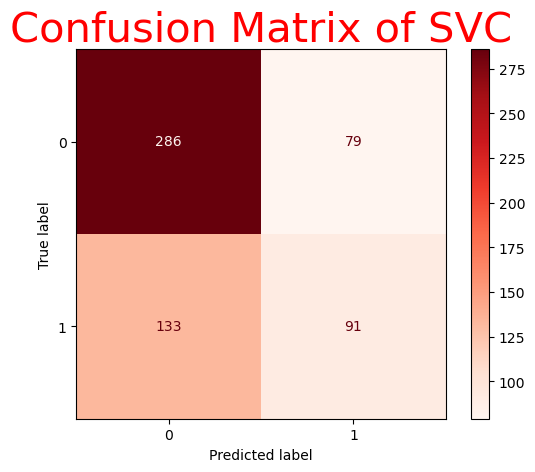

In [27]:
# cm for SVC
cm = confusion_matrix(y_test, best_svc_y_pred)

# customize confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=data_quality_names)

cm_display.plot(cmap=plt.cm.Reds) 

plt.title('Confusion Matrix of SVC', fontsize=30, color='red')

plt.show()

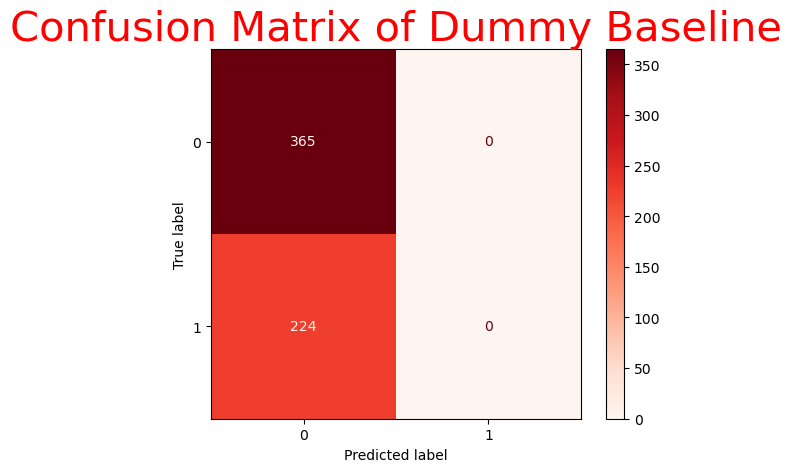

In [28]:
# cm for dummy baseline
cm = confusion_matrix(y_test, dummy_model_y_pred)

# customize confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=data_quality_names)

cm_display.plot(cmap=plt.cm.Reds) 

plt.title('Confusion Matrix of Dummy Baseline', fontsize=30, color='red')

plt.show()

From the confusion matrix shown above for the dummy baseline model, we can tell that it just predicted all 0s for all the data since the majority of the dataset has the target as 0

### 3. Determine Which Features The SVC Model Considers Important

permutation_importance takes a trained model and permutates each feature and scores the model. It will then compare the scores between the model without permutated features and the model with permutated features to see whether the features affects the score of the model. If there is a significant difference in the scores, it means that the feature has a great impact on the model's performance and hence is important. The function will repeat this step for n_repeats number of times before it permutates the next feature and so on. It can only be used for models with a rbf kernel, but since our SVC model happens to be using it, we can use permutation_importance to do so

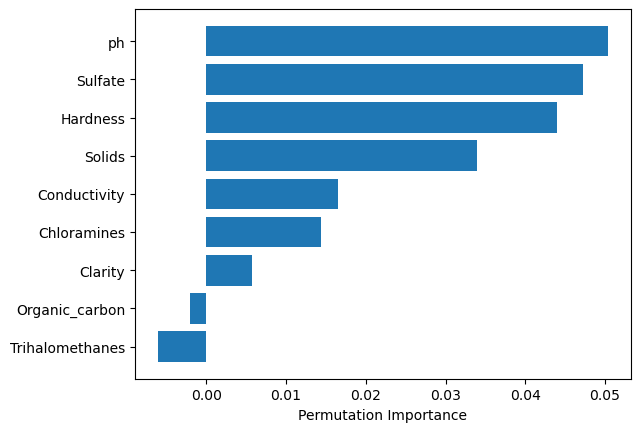

In [30]:
perm_importance = permutation_importance(best_svc, X_test_scaled, y_test, n_repeats=10, n_jobs=-1, random_state=42)  # n_repeats -> repeats the permutation and scoring of each feature by n times

features = np.array(list(df.drop('Quality', axis=1).columns))

sorted_idx = perm_importance.importances_mean.argsort()  # sort the index of each feature's mean score differences in ascending order

plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])  # plot a horizontal bar plot for all the scores and its respective feature names
plt.xlabel('Permutation Importance')

plt.show()

From the horizontal bar plot shown above, we can tell that the top 3 features that are deemed important by the SVC model are pH, Sulfate and Hardness in determining the quality of water. The negative permutation importance scores for Organic_carbon and Trihalomethanes means that they perform better when randomized, suggesting that they are not important

# 4. Conclusion

To summarise the process of training this Classfication model:

## A. Did you process the features in any way?

Yes, I first removed outliers from each of the features. Then, I imputed missing values with the mean of each of the features. Finally, I scaled the data.

## B. How did you select which learning algorithms to use?

I chose LogisticRegression, SVC, DecisionTreeClassifier, GaussianBayes and KNN as they are the most popular ones and are found in the lecture slides.

## C. Did you try to tune the hyperparameters of the learning algorithm, and in that case how?

Yes, I first googled and found parameters and their respective value ranges for some of the models. For those which were not included in the website, I went to the documentation to see what parameters were there for the remaining models and randomly chose values for those parameters.

Then, I tuned the hyperparameters by using GridSearchCV which will split the training data into n_folds and select one of the folds as the validation set. It will then train the model using the remaining n-1 folds of data and use the validation set to test and score. It will repeat this for n times and for every possible combination of parameters.

However, before hypertuning, I decided to test and see which models perform best with which type of data (scaled/unscaled and with outliers/without ouliers) and fit each model with its resepctive type of data to achieve the best score possible for each model.

## D. How do you evaluate the quality of your system?

I used f1_weighted score as the main evaluation of the quality of my best chosen model as it takes into account which takes into account the false positives and false negatives. It also assigns weights to each class based on the number of instances in that class which gives a score representative of the imbalance in the class. 

## E. How well does your system compare to a dummy baseline?

The f1-weighted score of the SVC model was 32% better than the dummy baseline model.

## F. Is it possible to say something about which features the model considers important?

The top 3 features that are deemed important by the SVC model are pH, Sulfate and Hardness in determining the quality of water which are determined by using sklearn.inspection.permutation_importance.